In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from causallib.estimation import IPW


In [112]:
def generate_data(n=1000, seed=0):
    rng = np.random.default_rng(seed)
    
    X = rng.normal(0, 0.5, size=(n, 4))
    a_beta = np.array([0, 1, 0, 1])
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.array([0, 0, -1, -1])
    effect = 1
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=["x0", "xa", "xy", "xay"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [113]:
X, a, y = generate_data()
X.join(a).join(y)

,x0,xa,xy,xay,a,y
0,0.062865,-0.066052,0.320211,0.052450,1,1.477364
1,-0.267835,0.180798,0.652000,0.473540,0,-1.847662
2,-0.351868,-0.632711,-0.311637,0.020663,0,0.689057
3,-1.162515,-0.109396,-0.622955,-0.366134,0,1.917618
4,-0.272129,-0.158150,0.205815,0.521257,1,-1.060988
...,...,...,...,...,...,...
995,-0.450861,1.003341,0.823907,-0.154471,1,1.280002
996,-0.827534,-0.510914,-0.101346,-0.120888,1,2.251462
997,0.859242,-0.639025,-0.057299,-0.096433,1,1.472600
998,0.411003,-0.116951,-0.140148,-0.009453,0,1.207335


In [114]:
ipw = IPW(LogisticRegression(penalty="none"))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)

In [115]:
def calculate_asmd(X, a, w=None):
    eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    smds = (x1_mean - x0_mean) / np.sqrt(x0_var + x1_var + eps)
    asmds = smds.abs()
    asmds.name = "asmd"
    return asmds

In [116]:
asmds = pd.concat({
    "weighted": calculate_asmd(X, a, w),
    "unweighted": calculate_asmd(X, a),
}, names=["adjustment", "covariate"])
asmds

adjustment  covariate
weighted    x0           0.002535
            xa           0.001482
            xy           0.000966
            xay          0.002014
unweighted  x0           0.015296
            xa           0.314791
            xy           0.053678
            xay          0.209638
Name: asmd, dtype: float64

Feature importance measures:
  * absolute coefficients (regression)
  * impurity-based importance (random forest)
  * permutation-based importance (random forest)
  * leave-one-out compare some loss/accuracy (generic)[sounds like a Harrell thing]
    * decrease in accuracy

In [117]:
def leave_one_out_importance(estimator, X, a, y):
    results = []

    for col in ["full"] + X.columns.tolist():
        curX = X.drop(columns=col, errors="ignore")
        curXa = curX.join(a)
        estimator.fit(curXa, y)
        y_pred = estimator.predict(curXa)
        result = {
            "covariate": col,
            "r2": r2_score(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
        }
        results.append(result)
    results = pd.DataFrame(results)
    return results

def relative_explained_variation(estimator, X, a, y, metric="mse"):
    """Harrell: https://www.fharrell.com/post/addvalue/"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = importance / importance.loc["full"]
    importance = importance.drop(index="full")
    importance = importance[metric]
    return importance

def decrease_in_explain_variation(estimator, X, a, y, metric="mse"):
    """https://stackoverflow.com/q/31343563"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = (importance.loc["full"]-importance) / importance.loc["full"]
    importance = importance.drop(index="full")
    importance = importance[metric]
    importance = importance.abs()
    return importance


In [118]:
# i = leave_one_out_importance(LinearRegression(), X, a, y)
# i = i.set_index("covariate")
# i
# relative_explained_variation(LinearRegression(), X, a, y)
feature_importance = decrease_in_explain_variation(LinearRegression(), X, a, y)
feature_importance

covariate
x0     0.000235
xa     0.000025
xy     0.266615
xay    0.225322
Name: mse, dtype: float64

In [128]:
plot_data = asmds.reset_index().merge(
    feature_importance.reset_index(), on="covariate",
)
plot_data

,adjustment,covariate,asmd,mse
0,weighted,x0,0.002535,0.000235
1,weighted,xa,0.001482,0.000025
2,weighted,xy,0.000966,0.266615
3,weighted,xay,0.002014,0.225322
4,unweighted,x0,0.015296,0.000235
5,unweighted,xa,0.314791,0.000025
6,unweighted,xy,0.053678,0.266615
7,unweighted,xay,0.209638,0.225322


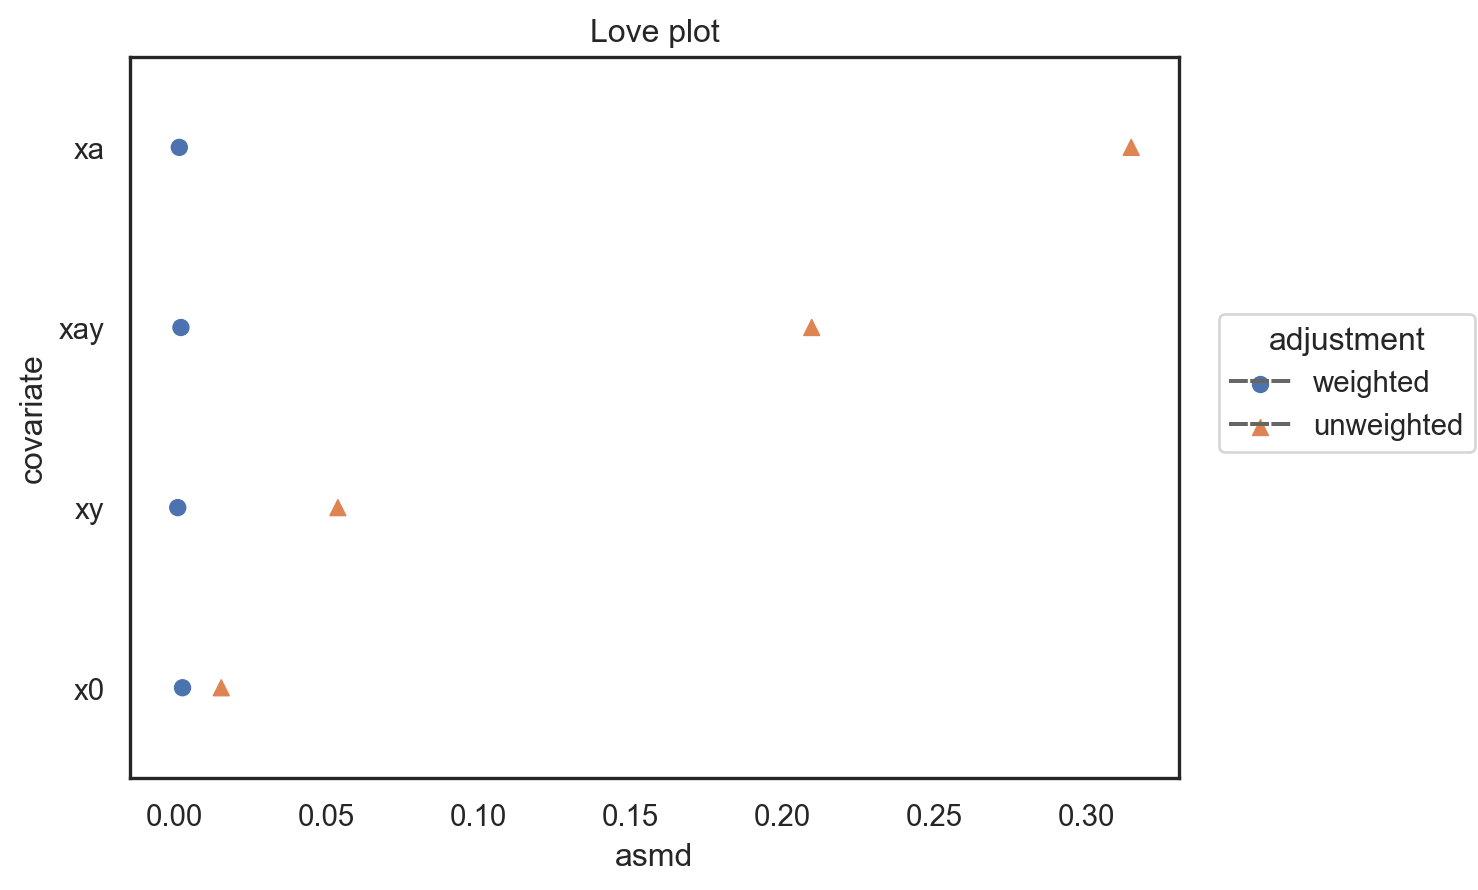

In [131]:
p = so.Plot(
    data=plot_data,
    x="asmd",
    y="covariate",
    color="adjustment",
    marker="adjustment",
).add(
    so.Dot()
).add(
    so.Range(linestyle="--", color="0.4"), 
    xmin="min", xmax="max", 
    data=plot_data.pivot(
        columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns"),
).scale(
    marker=dict(weighted="o", unweighted="^"),
    y=so.Nominal(order=plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()),
).theme(
    # {**sns.axes_style("whitegrid"), "grid.linestyle": ":"}
    sns.axes_style("white")
).label(
    title="Love plot"
)
p

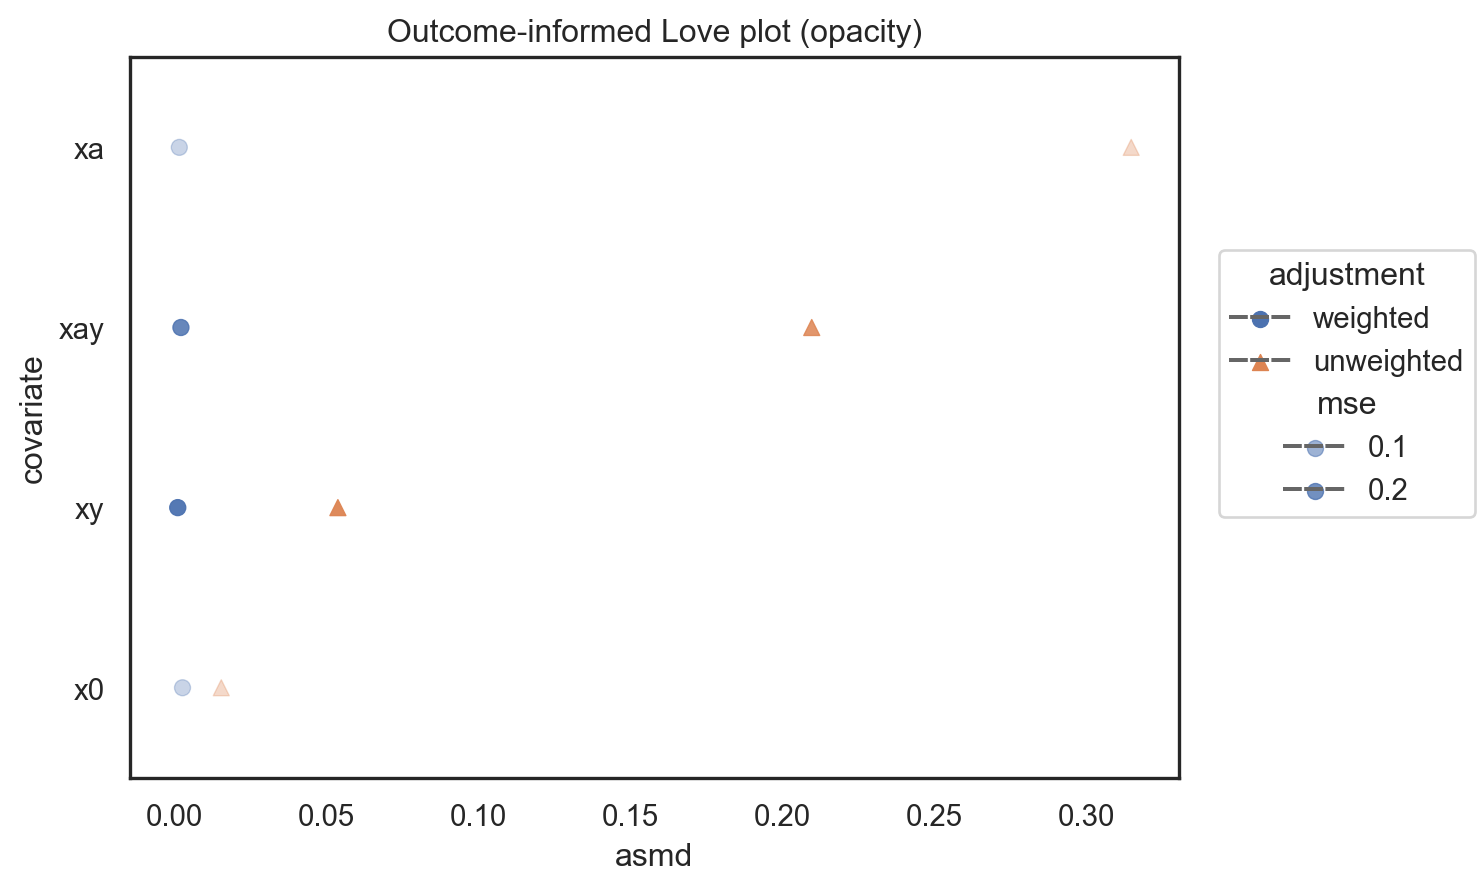

In [134]:
p = so.Plot(
    data=plot_data,
    x="asmd",
    y="covariate",
    color="adjustment",
    marker="adjustment",
    alpha="mse",
).add(
    so.Dot()
).add(
    so.Range(linestyle="--", color="0.4"), 
    xmin="min", xmax="max", 
    data=plot_data.pivot(
        columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns"),
).scale(
    marker=dict(weighted="o", unweighted="^"),
    y=so.Nominal(order=plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()),
).theme(
    # {**sns.axes_style("whitegrid"), "grid.linestyle": ":"}
    sns.axes_style("white")
).label(
    title="Outcome-informed Love plot (opacity)"
)
p

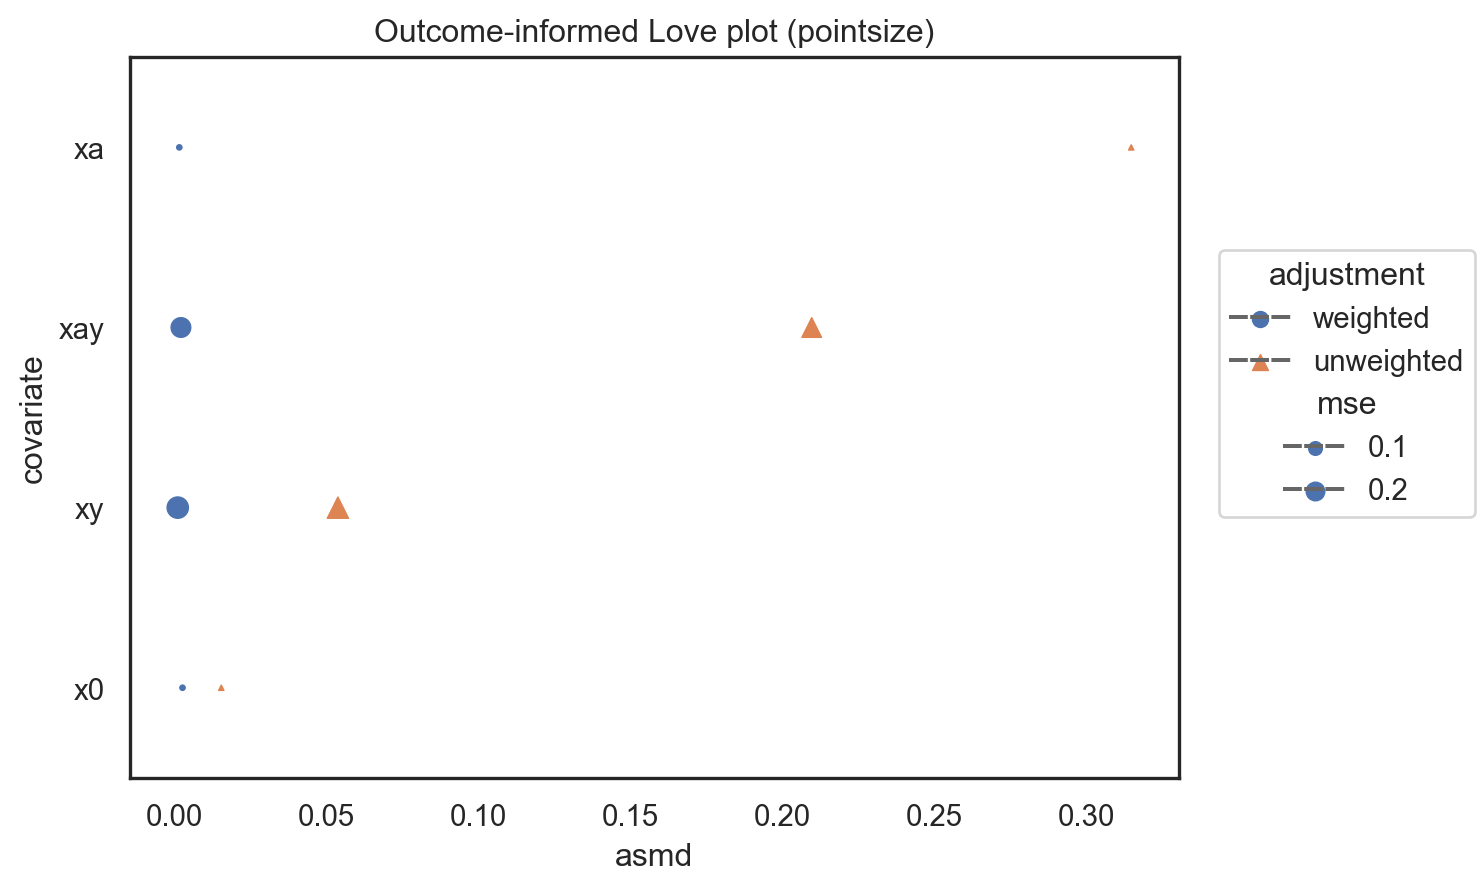

In [135]:
p = so.Plot(
    data=plot_data,
    x="asmd",
    y="covariate",
    color="adjustment",
    marker="adjustment",
    pointsize="mse",
).add(
    so.Dot()
).add(
    so.Range(linestyle="--", color="0.4"), 
    xmin="min", xmax="max", 
    data=plot_data.pivot(
        columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns"),
).scale(
    marker=dict(weighted="o", unweighted="^"),
    y=so.Nominal(order=plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()),
).theme(
    # {**sns.axes_style("whitegrid"), "grid.linestyle": ":"}
    sns.axes_style("white")
).label(
    title="Outcome-informed Love plot (pointsize)"
)
p

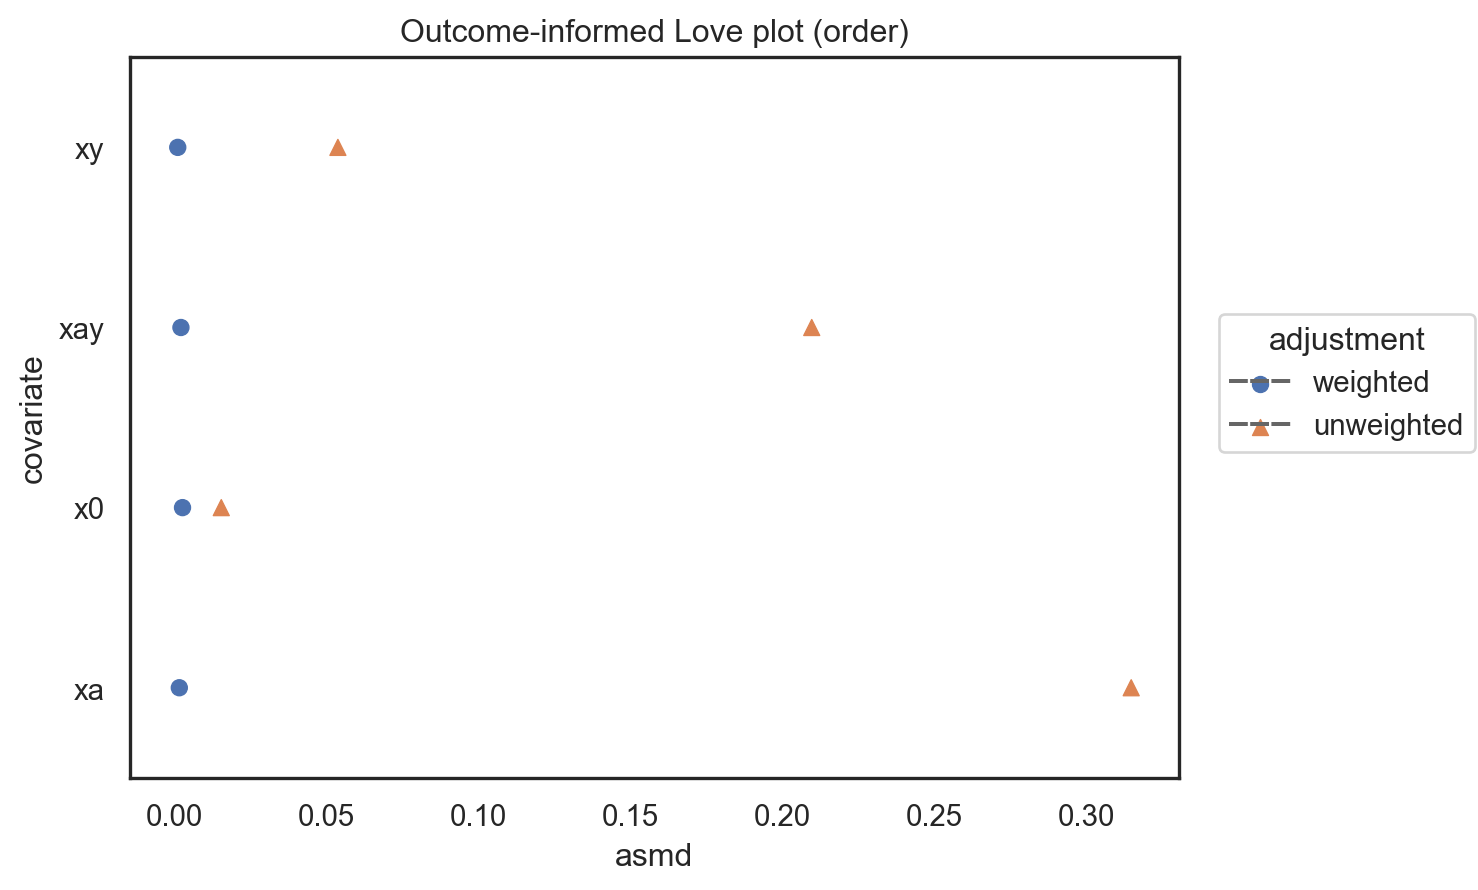

In [138]:
p = so.Plot(
    data=plot_data,
    x="asmd",
    y="covariate",
    color="adjustment",
    marker="adjustment",
).add(
    so.Dot()
).add(
    so.Range(linestyle="--", color="0.4"), 
    xmin="min", xmax="max", 
    data=plot_data.pivot(
        columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns"),
).scale(
    marker=dict(weighted="o", unweighted="^"),
    y=so.Nominal(order=plot_data.query("adjustment=='unweighted'").sort_values("mse", ascending=False)["covariate"].tolist()),
).theme(
    # {**sns.axes_style("whitegrid"), "grid.linestyle": ":"}
    sns.axes_style("white")
).label(
    title="Outcome-informed Love plot (order)"
)
p

In [145]:
fig = mpl.figure.Figure()
axes = fig.subplot_mosaic("ABCD")

{'A': <Axes: label='A'>,
 'B': <Axes: label='B'>,
 'C': <Axes: label='C'>,
 'D': <Axes: label='D'>}

## Combinging ASMD and FI in a single metric to allow selection